<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/visualising_sector_correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Analytics

## Visualising correlations between asset prices 

---------------------------

<img src='https://github.com/anirbanghoshsbi/asset_price_correlations/blob/master/assets/stock_correlations_gif.gif?raw=1' style="width:500px;height:500px;"></img>


### Topics covered
- __Calculating correlations between asset classes__
- __Heatmap visualisation using seaborn__
- __Network analysis and visualisation using Networkx__
- __Minimum spanning trees__
- __Interactive visualisations using Plotly__


### Introduction


Network analysis is becoming an ever increasingly popular method to analyse and visualise complex relationships in data in an intuitive way. 

One interesting application of network analytics is visualising relationships between asset classes in the finance industry. We are always told that equities and bonds tend to move in [opposite directions](https://vanguardblog.com/2018/07/09/exploring-the-relationship-between-stocks-and-bonds/) and certain assets such as gold and the Japanese Yen are 'safe-haven' assets and therefore behave in similar ways. But what does that actually _look_ like and are there any other interesting relationships between asset classes? Networks can be a great way to convey this information at a high level and help understand broad market dynamics.

Information on the correlations between asset classes can be particularly useful for investors wanting to diversify their portfolio. Most people understand that portfolio risk can be mitigated by diversification, however, this may not always be the case. For instance if you 'diversified' your portfolio by investing in two different stocks which are strongly correlated with each other (i.e. if stock A goes up 2% then stock B also goes up 2%) then the overall risk of the portfolio has not been reduced as if there is a negative factor affecting stock A then it is also likely to affect stock B and both prices will trend downwards. Therefore, diversification can only be realistically achieved by investing in assets which are uncorrelated with each other. Good explanations of this phenomenon can be found at [Quantdare](https://quantdare.com/correlation-prices-returns/) and the [Investors Chronicle](https://www.investorschronicle.co.uk/managing-your-money/2018/10/11/how-to-diversify-in-a-correlated-world/).

In this post I will explain how we can visualise asset correlations as an interactive network diagram which allows the user to gain a high level overview of the relationships between asset classes. From this information they can identify areas of risk but also opportunities for diversification of their portfolio. We will cover the basics of how to calculate correlations between asset price returns using numpy and pandas, using networkx to create a network graph and finally use Plotly to display the network as an interactive visualisation.


### Library imports

- __numpy__ and __pandas__ to read and manipulate the raw data
- __networkx__ to generate the network representation of the data and create some initial graph visualisations
- __matplotlib__ and __seaborn__ for general visualisations and plot formatting
- __Plotly__ to create the final interactive visualisation

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import seaborn as sns
from plotly.offline import init_notebook_mode

# plotly offline mode
init_notebook_mode(connected=True)

In [ ]:
# import warnings
# # filte
# warnings.filterwarnings("ignore")

# notebook formatting
from IPython.core.display import HTML, display

--------------------------

## Load data

For this analysis we will use a dataset containing the daily adjusted closing prices of 39 major ETFs which represent different asset classes covering equities, bonds, currencies and commodities. The data covers a period of 4 years between November 2013 and November 2017.

In [ ]:
!pip install quandl

In [ ]:
import quandl
import pandas as pd
import numpy as np
import requests
from quandl.errors.quandl_error import NotFoundError
import matplotlib.pyplot as plt

In [ ]:
ind=['SPBDISBT','SPBSMOIP','SI1200','SI1400','SIBANK','SIPOWE','SIREAL','SPBSTLIP','SPBSUTIP','SI1900','SI0800','SI1000','SPBSIDIP','SPBSFIIP']

In [ ]:
startdate='2019-01-01' #'SPBSGLDH',


In [ ]:
#@title Download from BSE
def download_from_BSE(datadump,startdate):
    data= {}
    df=pd.DataFrame()
    
    print(f'len of datadump {len(datadump)}')
    try:
      for i in range(len(datadump)):
          data[datadump[i]]= quandl.get('BSE/'+datadump[i],start_date=startdate,authtoken="1Mz3xLNFNdUpKENCkArB")['Close']
          
          
      i=0
      for key , value in data.items():
        df.insert(i, key, value)
        i=i+1
    except NotFoundError:
      pass

    return df

In [ ]:
raw_asset_prices_df= download_from_BSE(ind,startdate)

len of datadump 14


In [ ]:
# get number of rows and columns of the dataset
df_shape = raw_asset_prices_df.shape
print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset")
print(
    (
        f"Data timeperiod covers: {min(raw_asset_prices_df.index)} "
        f"to {max(raw_asset_prices_df.index)}"
    )
)

There are 613 rows and 14 columns in the dataset
Data timeperiod covers: 2019-01-01 00:00:00 to 2021-07-16 00:00:00


We can see that the csv file of asset prices contains 39 different assets and 1013 records for each asset. The time-series is in reverse order (newest to oldest) and there are no missing datapoints in the dataset. 

## Calculate asset price correlations

#### Convert to log returns

Before calculating the correlation matrix, it is important to first normalise the dataset and convert the absolute asset prices into daily returns. In financial time-series it is common to make this transformation as investors are typically interested in returns on assets rather than their absolute prices. By normalising the data it allows us to compare the expected returns of two assets more easily. 


In [ ]:
# create empty dataframe for log returns information
log_returns_df = pd.DataFrame()

# calculate log returns of each asset
# loop through each column in dataframe and and calculate the daily log returns
# add log returns column to new a dataframe
for col in raw_asset_prices_df.columns:
    # dates are given in reverse order so need to set diff to -1.
    log_returns_df[col] = np.log(raw_asset_prices_df[col]).diff(-1)

# check output of log returns dataframe
log_returns_df.head()

,SPBDISBT,SPBSMOIP,SI1200,SI1400,SIBANK,SIPOWE,SIREAL,SPBSTLIP,SPBSUTIP,SI1900,SI0800,SI1000,SPBSIDIP,SPBSFIIP
Date,,,,,,,,,,,,,,
2019-01-01,0.001253,0.008734,0.035104,0.012756,0.007743,0.015006,0.013180,0.013514,0.017260,0.030513,0.005372,-0.002831,0.011857,0.010133
2019-01-02,-0.000960,0.007311,0.023741,0.017678,0.007468,0.013801,0.000414,-0.005715,0.011731,0.014678,0.010375,0.008972,0.012547,0.010006
2019-01-03,0.000470,0.002624,-0.014316,-0.008215,-0.009401,-0.009664,-0.006883,-0.026931,-0.010208,-0.004213,-0.005834,0.011552,-0.002138,-0.009660
2019-01-04,0.005124,-0.003962,0.001655,-0.001826,-0.003713,-0.010206,-0.015397,-0.012493,-0.011318,0.000156,0.003887,-0.010997,0.000779,-0.000186
2019-01-07,0.000118,-0.000116,-0.005796,0.001713,-0.013042,0.002970,0.001950,-0.013331,0.003624,-0.003854,-0.009754,0.000649,0.000992,-0.004794


#### Calculate correlations matrix

To calculate the pairwise correlations between assets we can simply use the inbuilt pandas _corr()_ function.

In [ ]:
# calculate correlation matrix using inbuilt pandas function
correlation_matrix = log_returns_df.corr()

# show first five rows of the correlation matrix
correlation_matrix.head()

,SPBDISBT,SPBSMOIP,SI1200,SI1400,SIBANK,SIPOWE,SIREAL,SPBSTLIP,SPBSUTIP,SI1900,SI0800,SI1000,SPBSIDIP,SPBSFIIP
SPBDISBT,1.000000,0.011742,-0.060038,-0.051569,-0.005129,-0.034891,-0.043099,-0.017499,-0.037161,-0.034235,-0.015032,0.051018,-0.021545,-0.007778
SPBSMOIP,0.011742,1.000000,0.687417,0.703421,0.795545,0.680461,0.682371,0.545236,0.672564,0.787092,0.696856,0.654300,0.805307,0.811489
SI1200,-0.060038,0.687417,1.000000,0.722630,0.629623,0.703362,0.624599,0.453079,0.710401,0.696266,0.586801,0.469788,0.747222,0.644850
SI1400,-0.051569,0.703421,0.722630,1.000000,0.625065,0.712697,0.605617,0.423596,0.785653,0.675495,0.595728,0.455313,0.745024,0.643689
SIBANK,-0.005129,0.795545,0.629623,0.625065,1.000000,0.616726,0.715505,0.481539,0.587816,0.735501,0.463137,0.450999,0.801690,0.981519


### Correlations Heatmap

The conventional way to visualise correlations is via a heatmap. Before developing the network visualisation, we will quickly create a heatmap of the correlation matrix to check the output of the correlation calculations and to gain a high level insight into some of the relationships present in the data. 

Seaborn has a very useful function called _clustermap_ which visualises the matrix as a heatmap but also clusters the ETFs so that ETFs which behave similarly are next to each other. Clustered heatmaps can be a useful way of visualising correlations between attributes in a dataset, especially if the data is highly dimensional as it automatically reorders attributes which are similar to each other into clusters. This makes the heatmap more structured and readable so it is easier to identify relationships between ETFs and which asset classes behave similarly.

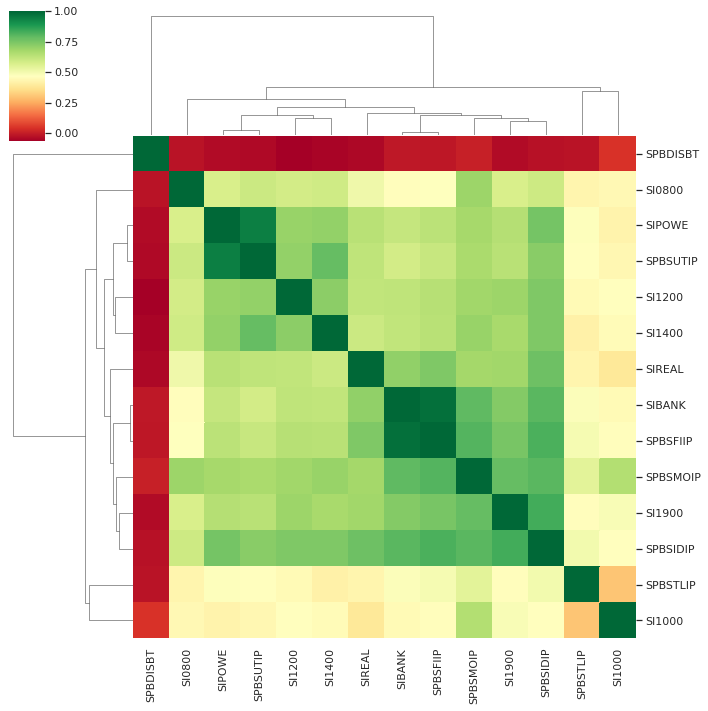

In [ ]:
# visualise correlation matrix using a clustered heatmap
display(HTML("<h3>Clustered Heatmap: Correlations between asset price returns</h3>"))
sns.clustermap(correlation_matrix, cmap="RdYlGn")
plt.show()

The heatmap is colour coded using a divergent colourscale where strong positive correlations (correlation = 1) are dark green, uncorrelated assets are yellow (correlation = 0) and negatively correlated assets are red (correlation = -1).

The clustered heatmap visualisation already gives a good picture of the data and tells an interesting story:
1. Broadly speaking, there are two major clusters of assets. These appear to be separated into equities and "non-equity" assets (e.g. bonds, currencies and precious metals). The heatmap shows that these two categories are generally negatively or non-correlated with each other which is expected as 'safe haven' assets such as bonds, gold and currencies like the Japanese Yen tend to move in opposite directions to equities which are seen as a riskier asset class. 
2. ETFs tracking Geographic regions which are close to each other are highly correlated with each other. For example, UK, Europe, Germany, Italy and France ETFs are highly correlated with each other, so are Japan, Pacific ex Japan and China ETFs
3. The VXX ETF is strongly negatively correlated with equities.  


## Network Visualisations

Heatmaps are useful, however, they can only convey one dimension of information (the magnitude of the correlation between two assets). As an investor wanting to make a decision on which asset classes to invest in, a heatmap still does not help answer important questions such as what the annualized returns and volatility of an asset class is. 

We can use network graphs  to investigate the initial findings from the heatmap further and visualise them in a more accessible way which encodes more information.

### Networkx

[Networkx](https://networkx.github.io/documentation/stable/) is one of the most popular and useful Python libraries for analysing small/medium size networks. 

In order to analyse the the correlations matrix as a network we first need to convert the correlations between assets to an edge list. This is a list containing information for each connection between each asset ETF in our data. This format requires the 'source' node (ETF), the 'target' node and the 'weight' (correlation) of the link between the two.

__Create edge list__

In [ ]:
# convert matrix to list of edges and rename the columns
edges = correlation_matrix.stack().reset_index()
edges.columns = ["asset_1", "asset_2", "correlation"]

# remove self correlations
edges = edges.loc[edges["asset_1"] != edges["asset_2"]].copy()

# show the first 5 rows of the edge list dataframe.
edges.head()

,asset_1,asset_2,correlation
1,SPBDISBT,SPBSMOIP,0.011742
2,SPBDISBT,SI1200,-0.060038
3,SPBDISBT,SI1400,-0.051569
4,SPBDISBT,SIBANK,-0.005129
5,SPBDISBT,SIPOWE,-0.034891


__Create graph from edge list__

Now that we have an edge list we need to feed that into the networkx library to create a graph. Note that this network is undirected as the correlation between assets is the same in both directions.

In [ ]:
# create undirected graph with weights corresponding to the correlation magnitude
G0 = nx.from_pandas_edgelist(edges, "asset_1", "asset_2", edge_attr=["correlation"])

# print out the graph info
# check number of nodes and degrees are as expected
# (all should have degree = 38, i.e. average degree = 38)
print(nx.info(G0))

Name: 
Type: Graph
Number of nodes: 14
Number of edges: 91
Average degree:  13.0000


__Visualise the network__

To visualise the graph we have just created, we can use a number of 'out-of-the-box' layouts which can be drawn using networkx, for example:

- circular_layout - Position nodes on a circle. 
- random_layout - Position nodes uniformly at random in the unit square.
- spectral_layout - Position nodes using the eigenvectors of the graph Laplacian.  
- spring_layout - Position nodes using Fruchterman-Reingold force-directed algorithm.   


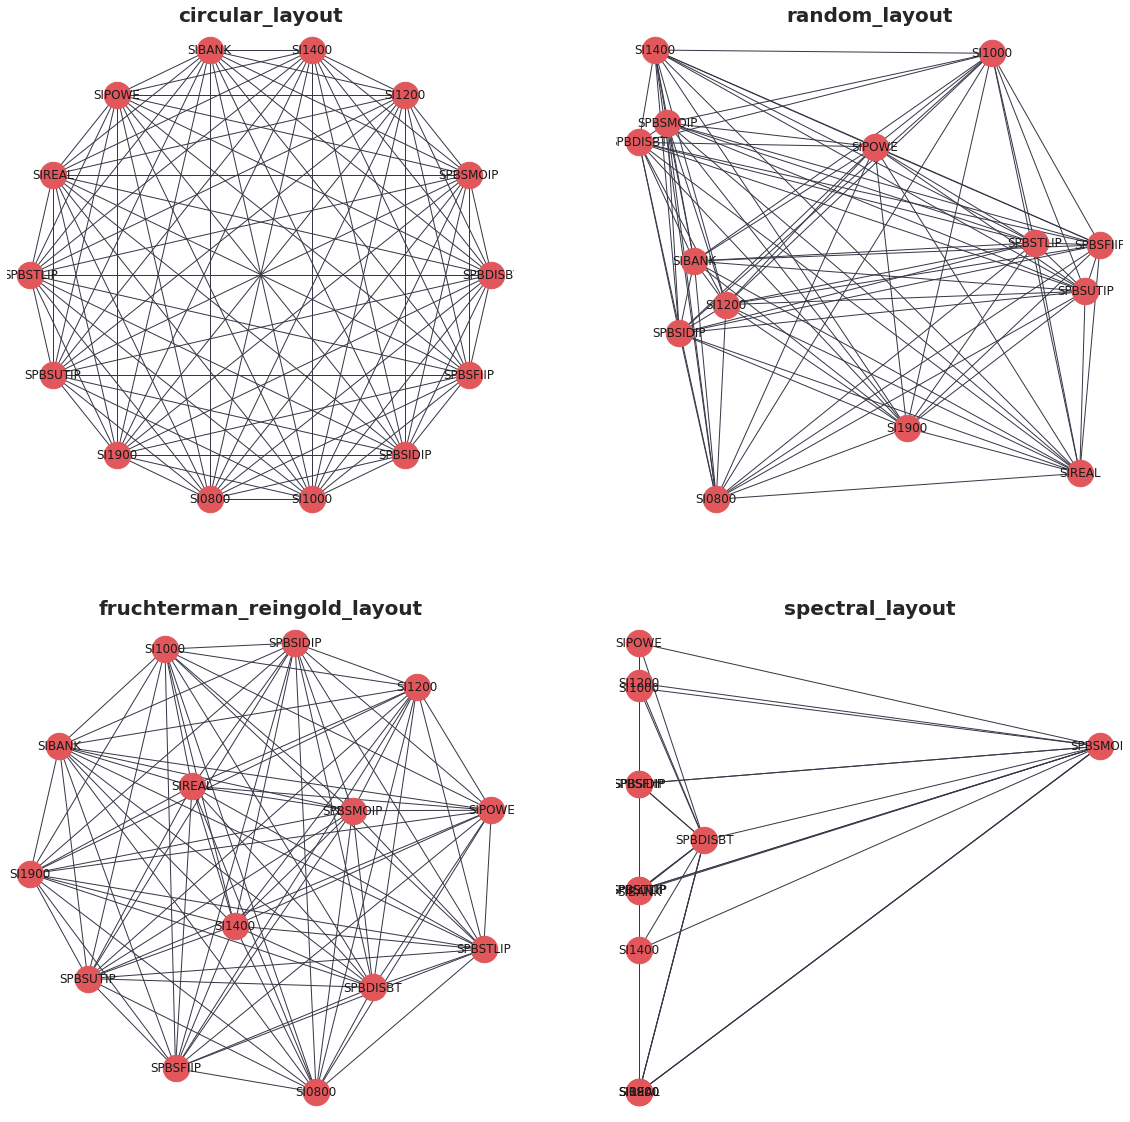

In [ ]:
# create subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

# save different layout functions in a list
layouts = [nx.circular_layout, nx.random_layout, nx.spring_layout, nx.spectral_layout]

# plot each different layout
for layout, ax in zip(layouts, axs.ravel()):
    nx.draw(
        G0,
        with_labels=True,
        node_size=700,
        node_color="#e1575c",
        edge_color="#363847",
        pos=layout(G0),
        ax=ax,
    )
    ax.set_title(layout.__name__, fontsize=20, fontweight="bold")

plt.show()

Whilst these visualisations may look cool, they are not very useful in their current form as all nodes have the same number of edges (links), and each edge looks the same so no useful information about the correlations between ETFs can be gained.

__Improved network visualisation__

The network visualisation can be improved in a number of ways by thinking about the sort of information which we are looking to uncover from this analysis. It is important to think about what questions we wish to answer from the data and then design the visualisation to gain the most insight for the question in hand. For the purposes of enhancing the visualisation, We will assume that the audience for this visualisation will be investors wanting to assess risk in their portfolio. Investors would want to identify which assets are correlated and uncorrelated with each other in order to assess the unsystematic risk in their portfolio. Therefore, from this visualisation the user would want to quickly understand:
- which assets show strong/meaningful correlations (i.e. >0.5) with each other
- are these correlations positive or negative
- which are the most/least 'connected' assets. (i.e. which assets share the most/least strong correlations with other assets in the dataset)
- which groups of assets behave similarly (i.e. which assets are correlated with the same type of other assets)

With this information, an investor could identify if they held a number of assets which behave the same (increased risk) and identify assets which show very few correlations with assets currently held in the portfolio and investigate these as a potential opportunity for diversification. 

For a first iteration to improve the network visualisation we can take the circular layout graph from above and make the following changes:
- reduce the number of connections between nodes by adding a threshold value for the strength of correlation
- introduce colour to signify positive or negative correlations
- scale the edge thickness to indicate the magnitude of correlation
- scale the size of nodes to indicate which assets have the greatest number of strong correlations with the rest of the assets in the dataset

##### Remove edges below a threshold

In [ ]:
# 'winner takes all' method - set minium correlation threshold to remove some
# edges from the diagram
threshold = 0.5

# create a new graph from edge list
Gx = nx.from_pandas_edgelist(edges, "asset_1", "asset_2", edge_attr=["correlation"])

# list to store edges to remove
remove = []
# loop through edges in Gx and find correlations which are below the threshold
for asset_1, asset_2 in Gx.edges():
    corr = Gx[asset_1][asset_2]["correlation"]
    # add to remove node list if abs(corr) < threshold
    if abs(corr) < threshold:
        remove.append((asset_1, asset_2))

# remove edges contained in the remove list
Gx.remove_edges_from(remove)

print(str(len(remove)) + " edges removed")

35 edges removed


##### Create colour, edge thickness and node size features

In [ ]:
def assign_colour(correlation):
    if correlation <= 0:
        return "#ffa09b"  # red
    else:
        return "#9eccb7"  # green


def assign_thickness(correlation, benchmark_thickness=2, scaling_factor=3):
    return benchmark_thickness * abs(correlation) ** scaling_factor


def assign_node_size(degree, scaling_factor=50):
    return degree * scaling_factor


# assign colours to edges depending on positive or negative correlation
# assign edge thickness depending on magnitude of correlation
edge_colours = []
edge_width = []
for key, value in nx.get_edge_attributes(Gx, "correlation").items():
    edge_colours.append(assign_colour(value))
    edge_width.append(assign_thickness(value))

# assign node size depending on number of connections (degree)
node_size = []
for key, value in dict(Gx.degree).items():
    node_size.append(assign_node_size(value))

##### Draw improved graph

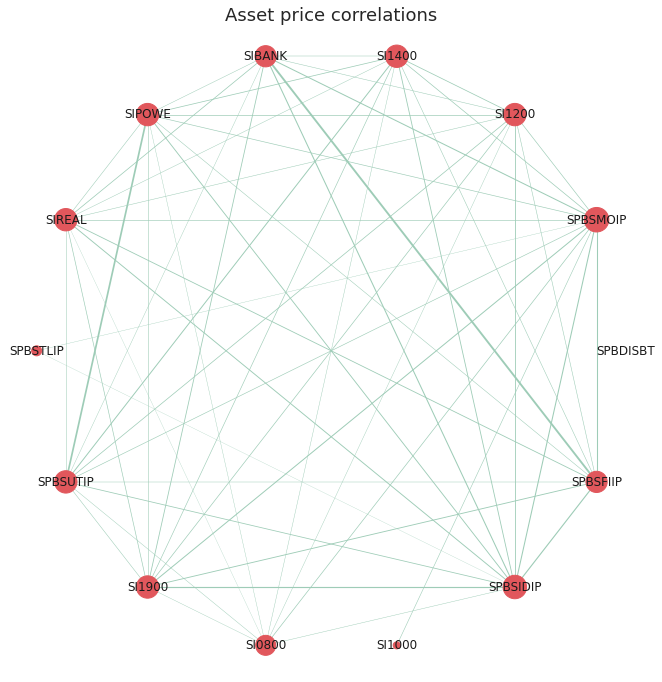

In [ ]:
# draw improved graph
sns.set(rc={"figure.figsize": (9, 9)})
font_dict = {"fontsize": 18}

nx.draw(
    Gx,
    pos=nx.circular_layout(Gx),
    with_labels=True,
    node_size=node_size,
    node_color="#e1575c",
    edge_color=edge_colours,
    width=edge_width,
)
plt.title("Asset price correlations", fontdict=font_dict)
plt.show()

The network visualisation has been improved in four main ways:
- less cluttered: we have removed edges with weak correlations and kept only the edges with significant (actionable) correlations
- identify type of correlation: simple intuitive colour scheme to show positive (green) or negative (red) correlations 
- identify strength of correlation: we now are able to assess the relative strength of correlations between nodes, with prominence given to the correlations with the greatest magnitude
- identify the most connected nodes: the size of the nodes has been adjusted to emphasise which nodes have the greatest number of strong correlations with other nodes in the network

Looking at this network we could now quickly identify which assets are highly correlated and therefore may pose increased risk on the portfolio. The viewer could also identify and investigate further the assets with low degree of connectivity (smaller node size) as these are weakly correlated with the other assets in the sample and may provide an opportunity to diversify the portfolio.

The circular layout, however, does not group the nodes in a meaningful order, it just orders the nodes in the order in which they were created, therefore it is difficult to gain insight as to which assets are most similar to each other in terms of correlations to other nodes. We can improve this with a spring based layout using the 'Fruchterman-Reingold' algorithm [2] which sets the positions of the nodes using a cost function which minimises the distances between strongly correlated nodes. This algorithm will therefore cluster the nodes which are strongly correlated with each other allowing the viewer to quickly identify groups of assets with similar properties.

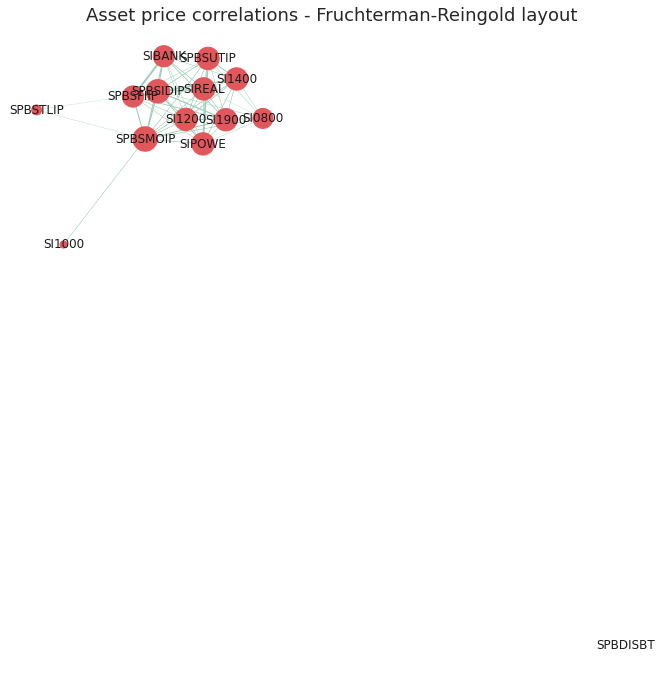

In [ ]:
# draw improved graph
nx.draw(
    Gx,
    pos=nx.fruchterman_reingold_layout(Gx),
    with_labels=True,
    node_size=node_size,
    node_color="#e1575c",
    edge_color=edge_colours,
    width=edge_width,
)
plt.title("Asset price correlations - Fruchterman-Reingold layout", fontdict=font_dict)
plt.show()

The Fruchterman Reingold layout has successfully grouped the assets into clusters of strongly correlated assets. As seen before in the heatmap visualisation, there are distinct clusters of assets which behave similarly to each other. There is a cluster containing bond ETFs, a cluster of precious metal ETFs (silver, gold, goldminers), a cluster of currencies (CHF, USD, Euro) and a large cluster for equities.

However, the main cluster of equities ETFs is still very cluttered as the nodes are very tightly packed and the node sizes and labels are overlapping making it difficult to make out.

As the layout now positions the nodes which are strongly correlated in space, it is no longer necessary to keep every single edge as it is implied that assets closer to each other in space are more strongly correlated. We can also convert the node sizes back to a consistent (smaller) size as the degree of each node is now meaningless.

##### Minimum spanning tree

It is common in financial networks to use a minimum spanning tree [3,4,5] to visualise networks. A minimum spanning tree reduces the edges down to a subset of edges which connects all the nodes together, without any cycles and with the minimum possible sum of edge weights (correlation value in this case). This essentially provides a skeleton of the graph, minimising the number of edges and reducing the clutter in the network graph. 

[Kruskal's algorithm](https://en.wikipedia.org/wiki/Kruskal%27s_algorithm) is used to calculate the minimum spanning tree and is fairly intuitive. However, Networkx has an inbuilt function which calculates the minimum spanning tree for us. 

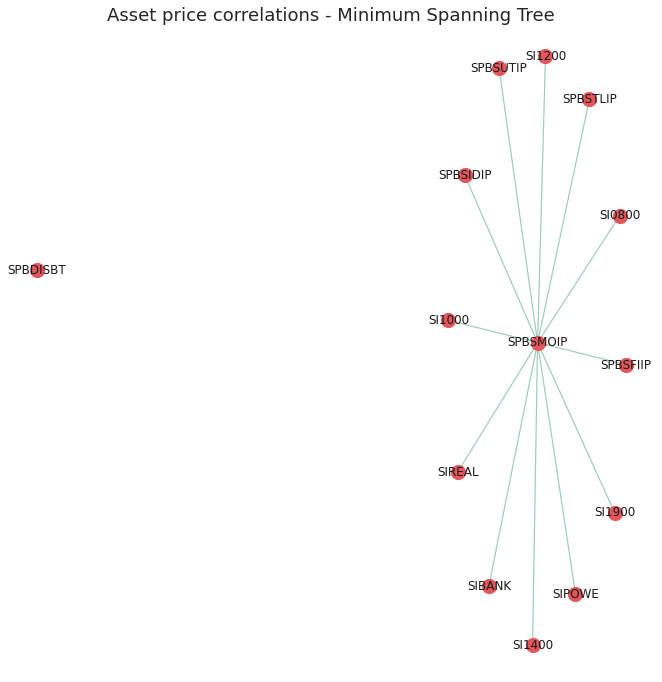

In [ ]:
# create minimum spanning tree layout from Gx
# (after small correlations have been removed)
mst = nx.minimum_spanning_tree(Gx)

edge_colours = []

# assign edge colours
for key, value in nx.get_edge_attributes(mst, "correlation").items():
    edge_colours.append(assign_colour(value))


# draw minimum spanning tree. Set node size and width to constant
nx.draw(
    mst,
    with_labels=True,
    pos=nx.fruchterman_reingold_layout(mst),
    node_size=200,
    node_color="#e1575c",
    edge_color=edge_colours,
    width=1.2,
)

# set title
plt.title("Asset price correlations - Minimum Spanning Tree", fontdict=font_dict)
plt.show()

The improved graph has made the clusters of nodes more readable by reducing the node size and reducing the number of edges in the graph. However, reducing the clutter was at the expense of conveying some information about the nodes such as nodes with the most strong correlations and their relative strengths.

## Interactive visualisation

Finally, I will explore the use of interactive plotting libraries to enhance the user experience and alleviate some of the missing information issues with the use of informative tooltips. 

Currently the network is very 'static' and does not convey any information other than spacial relationships between strongly correlated assets. Although useful, this logically leads the viewer to ask more questions about the properties of each individual node in a cluster such as their historical returns and the nodes with which it is least correlated to.

One way to include such information about each node is to use an interactive graph with informative tooltips. This can be achieved using the Plotly[6] python library which offers a python api to create interactive javascript graphs built in d3.js. The following code uses the Plotly api to create a graph with the following features:
- interactivity, such as zoom, to focus on clusters of nodes
- tooltips which provides useful information about the node when the user hovers over it
- node sizes proportional to the annualised returns of each asset
- node colours to show asset positive or negative return over the dataset timeframe

#### Plotly

The Python code required for Ploty graphs can be a little bit more involved than out of the box matplotlib or seaborn charts but allows for much more customisation.

The main benefit of using Plotly in this example is the use of tooltips. In these tooltips we can store lots of additional information about each ETF which we can access by hovering over the respective node in the graph.

There are obviously many different bits of information of use which we could incorporate into the tooltip. For this example I will add:
- annualised returns of the asset class
- annualised volatility of the asset class
- the top and bottom 3 assets which the asset of interest is most/least strongly correlated with

##### Functions to get node information to populate tooltips

The following functions calculate the above quantities. It should be noted that Plotly tooltips are formatted using html. Therefore the input to the tooltip should be a string with the relevant html tags for any formatting that is required. 

In [ ]:
def convert_rankings_to_string(ranking):
    """
    Concatenate list of nodes and correlations into a single html
    string (required format for the plotly tooltip)

    Inserts html "<br>" inbetween each item in order to add a new
    line in the tooltip
    """
    s = ""
    for r in ranking:
        s += r + "<br>"
    return s


def calculate_stats(returns=log_returns_df):
    """calculate annualised returns and volatility for all ETFs

    Returns:
        tuple: Outputs the annualised volatility and returns as a list of
            floats (for use in assigning node colours and sizes) and also
            as a lists of formatted strings to be used in the tool tips.
    """

    # log returns are additive, 252 trading days
    annualized_returns = list(np.mean(returns) * 252 * 100)

    annualized_volatility = [
        np.std(returns[col] * 100) * (252 ** 0.5) for col in list(returns.columns)
    ]

    # create string for tooltip
    annualized_volatility_2dp = [
        "Annualized Volatility: " "%.1f" % r + "%" for r in annualized_volatility
    ]
    annualized_returns_2dp = [
        "Annualized Returns: " "%.1f" % r + "%" for r in annualized_returns
    ]

    return (
        annualized_volatility,
        annualized_returns,
        annualized_volatility_2dp,
        annualized_returns_2dp,
    )


def get_top_and_bottom_three(df=correlation_matrix):
    """
    get a list of the top 3 and bottom 3 most/least correlated assests
    for each node.

    Args:
        df (pd.DataFrame): pandas correlation matrix

    Returns:
        top_3_list (list): list of lists containing the top 3 correlations
            (name and value)
        bottom_3_list (list): list of lists containing the bottom three
            correlations (name and value)
    """

    top_3_list = []
    bottom_3_list = []

    for col in df.columns:

        # exclude self correlation #reverse order of the list returned
        top_3 = list(np.argsort(abs(df[col]))[-4:-1][::-1])
        # bottom 3 list is returned in correct order
        bottom_3 = list(np.argsort(abs(df[col]))[:3])

        # get column index
        col_index = df.columns.get_loc(col)

        # find values based on index locations
        top_3_values = [df.index[x] + ": %.2f" % df.iloc[x, col_index] for x in top_3]
        bottom_3_values = [
            df.index[x] + ": %.2f" % df.iloc[x, col_index] for x in bottom_3
        ]

        top_3_list.append(convert_rankings_to_string(top_3_values))
        bottom_3_list.append(convert_rankings_to_string(bottom_3_values))

    return top_3_list, bottom_3_list

##### Function to generate coordinates

Plotly does not have an 'out-of-the-box' network graph chart, therefore we need to 'imitate' the network layout by plotting the data as a scatter plot which plots the graph nodes, and plot a 'line' chart on top which draws the lines which connect each point. To achieve this we need a function which converts the Fruchterman Reingold coordinates calculated using networtx into an x and y series to create the scatter plot. We also need to store the x and y coordinates of the start and end of each edge which will be used to draw the 'line' chart.

The function calculates the x and y coordinates for the scatter plot (Xnodes and Ynodes) and the coordinates of the starting and ending positions of the lines connecting nodes (Xedges, Yedges):


In [ ]:
def get_coordinates(G=mst):
    """Returns the positions of nodes and edges in a format
    for Plotly to draw the network
    """
    # get list of node positions
    pos = nx.fruchterman_reingold_layout(mst)

    Xnodes = [pos[n][0] for n in mst.nodes()]
    Ynodes = [pos[n][1] for n in mst.nodes()]

    Xedges = []
    Yedges = []
    for e in mst.edges():
        # x coordinates of the nodes defining the edge e
        Xedges.extend([pos[e[0]][0], pos[e[1]][0], None])
        Yedges.extend([pos[e[0]][1], pos[e[1]][1], None])

    return Xnodes, Ynodes, Xedges, Yedges

__Plotly Graph Code__

Now we can finally plot the network as an interactive Plotly visualisation.

First, we need to calculate all the quantities and concatenate them into a html string to be used as an input for the tooltip. Then we need to calculate the coordinates for the scatter and line plots and finally define the node color and size which depend on the direction and size of the annualised returns.

In [ ]:
# get statistics for tooltip

# make list of node labels.
node_label = list(mst.nodes())
# calculate annualised returns, annualised volatility and round to 2dp
annual_vol, annual_ret, annual_vol_2dp, annual_ret_2dp = calculate_stats()
# get top and bottom 3 correlations for each node
top_3_corrs, bottom_3_corrs = get_top_and_bottom_three()


# create tooltip string by concatenating statistics
description = [
    f"<b>{node}</b>"
    + "<br>"
    + annual_ret_2dp[index]
    + "<br>"
    + annual_vol_2dp[index]
    + "<br><br>Strongest correlations with: "
    + "<br>"
    + top_3_corrs[index]
    + "<br>Weakest correlations with: "
    "<br>" + bottom_3_corrs[index]
    for index, node in enumerate(node_label)
]

# get coordinates for nodes and edges
Xnodes, Ynodes, Xedges, Yedges = get_coordinates()

# assign node colour depending on positive or negative annualised returns
node_colour = [assign_colour(i) for i in annual_ret]

# assign node size based on annualised returns size (scaled by a factor)
node_size = [abs(x) ** 0.5 * 5 for x in annual_ret]

To plot the network we define the scatter plot (tracer) and line plot (tracer_marker) series and define some cosmetic parameters which dictate the graph layout.

In [ ]:
# Plot graph

# edges
tracer = go.Scatter(
    x=Xedges,
    y=Yedges,
    mode="lines",
    line=dict(color="#DCDCDC", width=1),
    hoverinfo="none",
    showlegend=False,
)


# nodes
tracer_marker = go.Scatter(
    x=Xnodes,
    y=Ynodes,
    mode="markers+text",
    textposition="top center",
    marker=dict(size=node_size, line=dict(width=1), color=node_colour),
    hoverinfo="text",
    hovertext=description,
    text=node_label,
    textfont=dict(size=7),
    showlegend=False,
)


axis_style = dict(
    title="",
    titlefont=dict(size=20),
    showgrid=False,
    zeroline=False,
    showline=False,
    ticks="",
    showticklabels=False,
)


layout = dict(
    title="Plotly - interactive minimum spanning tree",
    width=800,
    height=800,
    autosize=False,
    showlegend=False,
    xaxis=axis_style,
    yaxis=axis_style,
    hovermode="closest",
    plot_bgcolor="#fff",
)


fig = go.Figure()
fig.add_trace(tracer)
fig.add_trace(tracer_marker)
fig.update_layout(layout)

fig.show()

display(
    HTML(
        """
        <p>Node sizes are proportional to the size of
        annualised returns.<br>Node colours signify positive
        or negative returns since beginning of the timeframe.</p>
        """
    )
)

In [ ]:
# Save interactive vis to json
fig.write_json("plotly_asset_prices_network.json")

With this final network layout, we have summarised the most important information about the relationships between assets in the dataset. Users can quickly identify clusters of assets which are strongly correlated with each other, gauge the performance of the asset over the timeframe by looking at the node sizes and colours and can get more detailed information about each node by hovering over it.


### Conclusion

In this post we have shown how to visualise a network of asset price correlations using the networkx python library. The 'out of the box' networkx visualisations were iteratively improved to help the audience identify assets which behave similarly to other assets in the dataset. This was achieved by reducing redundant information in the network and using intuitive colour schemes, edge thickness and node thickness to convey information in a qualitative way. The functionality of the visualisation was further improved by the use of Plotly, an interactive graphing library, which allowed us to use tooltips to store more information about each node in the network without cluttering the visualisation.


### Future Work

Further work could look at the rolling asset correlations over a shorter timeframe and see how these may have changed over time and how this then affects the network layout and clusters. This could help identify outliers or asset classes which are not behaving as 'normal'. There are also many more interesting calculations which can be carried out on the network, such as working out which are the most important or influential nodes in the networks by using centrality measures [7].

The post focused on how to visualise the network using networkx and Plotly, however, there are many other libraries and software which could have been used and are worth investigating:

__Open Source Python Libraries__
- Graphviz
- Pygraphviz

__Open Source Interactive Libraries__
- d3.js 

__Network drawing Software__
- Gelphi Gelphi (https://gephi.org/)


If you are interested in investigating network analytics in the financial industry in more detail, I would highly recommend checking out https://www.fnalab.com/ which is a commercial platform for financial network analytics. They have a free trial to their platform which has some very impressive network visualisations of the stock market but also financial transcations for fraud detection and many more applications.


## References




[1] Networkx documentation: https://networkx.github.io/documentation/stable/reference/drawing.html <br>
[2]  Fruchterman, T.M. and Reingold, E.M., 1991. Graph drawing by force-directed placement. 1991. Zitiert auf den, p.37. <br>
[3] Mantegna, R.N., 1999. Hierarchical structure in financial markets. The European Physical Journal B-Condensed Matter and Complex Systems, 11(1), pp.193-197. <br>
[4] Rešovský, M., Horváth, D., Gazda, V. and Siničáková, M., 2013. Minimum Spanning Tree Application in the Currency Market. Biatec, 21(7), pp.21-23. <br>
[5] Financial Network Analytics: https://www.fna.fi/ <br>
[6] Plotly: https://plot.ly/d3-js-for-python-and-pandas-charts/  
[7] Wenyue Sun, Chuan Tian, Guang Yang, 2015, [Network Analysis of the Stock Market](http://snap.stanford.edu/class/cs224w-2015/projects_2015/Network_Analysis_of_the_Stock_Market.pdf)